In [1]:
import pandas as pd
import numpy as np
import os
from run_fall_detection_model  import run_fall_detection_model


/Users/amir/Documents/projects/fall-detection/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
from data_reading_utils import uma_search_csv_files


falls_files = uma_search_csv_files(directory='output', activities_of_interest=['Activity13', 'Activity14', 'Activity15'])
adl_files = uma_search_csv_files(directory='output', activities_of_interest=['Activity1', 'Activity2', 'Activity3', 'Activity4', 'Activity5', 'Activity6', 'Activity7', 'Activity8', 'Activity9', 'Activity10', 'Activity11', 'Activity12'])

len(falls_files), len(adl_files)


(198, 678)

In [3]:
def load_and_pad(file, use_gyro=False, max_len=300):
    # Read the CSV file
    df = pd.read_csv(file)
    
    # Define the columns to use
    if use_gyro:
        cols = ['Accelerometer: x-axis (g)', 'Accelerometer: y-axis (g)', 'Accelerometer: z-axis (g)',
                'Gyroscope: x-axis (rad/s)', 'Gyroscope: y-axis (rad/s)', 'Gyroscope: z-axis (rad/s)']
    else:
        cols = ['Accelerometer: x-axis (g)', 'Accelerometer: y-axis (g)', 'Accelerometer: z-axis (g)']
    
    # Clean and convert data for each column
    for col in cols:
        if df[col].dtype == 'object':  # If column has string values
            # Replace incorrect number format (assuming European format with '.' as thousand separator)
            df[col] = df[col].astype(str).str.replace('.', '', n=1)  # Remove first period (thousand separator)
            df[col] = pd.to_numeric(df[col].str.replace(',', '.'), errors='coerce')  # Replace comma with period for decimal

    # Extract features and convert to numpy array
    features = df[cols].to_numpy().astype('float32')
    
    # Pad or truncate as needed
    if features.shape[0] > max_len:
        features = features[:max_len, :]
    elif features.shape[0] < max_len:
        pad = np.zeros((max_len - features.shape[0], features.shape[1]), dtype='float32')
        features = np.vstack((features, pad))
    
    return features




def build_dataset(falls_files, adl_files, max_len=300):
    X_acc, X_all, y = [], [], []

    for file in falls_files:
        X_acc.append(load_and_pad(file, use_gyro=False, max_len=max_len))
        X_all.append(load_and_pad(file, use_gyro=True, max_len=max_len))
        y.append(1)

    for file in adl_files:
        X_acc.append(load_and_pad(file, use_gyro=False, max_len=max_len))
        X_all.append(load_and_pad(file, use_gyro=True, max_len=max_len))
        y.append(0)

    return np.array(X_acc), np.array(X_all), np.array(y)



In [4]:
X_acc, X_all, y = build_dataset(falls_files, adl_files)


print("Accelerometer only:", X_acc.shape)
print("Accelerometer + Gyroscope:", X_all.shape)
print("Labels:", y.shape)

Accelerometer only: (876, 300, 3)
Accelerometer + Gyroscope: (876, 300, 6)
Labels: (876,)


In [5]:
from imblearn.over_sampling import SMOTE

USE_GYRO = False

X = X_all if USE_GYRO else X_acc
X_2d = X.reshape((X.shape[0], -1))

# Remove samples with NaNs
mask = ~np.isnan(X_2d).any(axis=1)
X_clean = X_2d[mask]
y_clean = y[mask]

print(f"Removed {len(y) - len(y_clean)} samples due to NaNs.")

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_clean, y_clean)

# Reshape back to 3D for CNN
X_resampled = X_resampled.reshape((-1, 300, X.shape[2]))

print("✅ SMOTE done:")
print("X shape:", X_resampled.shape)
print("Label counts:", np.bincount(y_resampled))

Removed 19 samples due to NaNs.
✅ SMOTE done:
X shape: (1318, 300, 3)
Label counts: [659 659]


/Users/amir/Documents/projects/fall-detection/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Removed 19 samples due to NaNs.
✅ SMOTE applied
X shape: (1318, 300, 3)
Label counts: [659 659]
Epoch 1/20


/Users/amir/Documents/projects/fall-detection/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6686 - loss: 0.5942 - val_accuracy: 0.7867 - val_loss: 0.4696
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8087 - loss: 0.4326 - val_accuracy: 0.7915 - val_loss: 0.4618
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8315 - loss: 0.4307 - val_accuracy: 0.7820 - val_loss: 0.4604
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8303 - loss: 0.3931 - val_accuracy: 0.7962 - val_loss: 0.4492
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8401 - loss: 0.3833 - val_accuracy: 0.7915 - val_loss: 0.4574
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8496 - loss: 0.3555 - val_accuracy: 0.7915 - val_loss: 0.4608
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8490 - loss: 0.3521 - val_accuracy: 0.7962 - val_loss: 0.4446
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8804 - loss: 0.3108 - val_accuracy: 0.7488 - val_loss: 0.5047
Epo

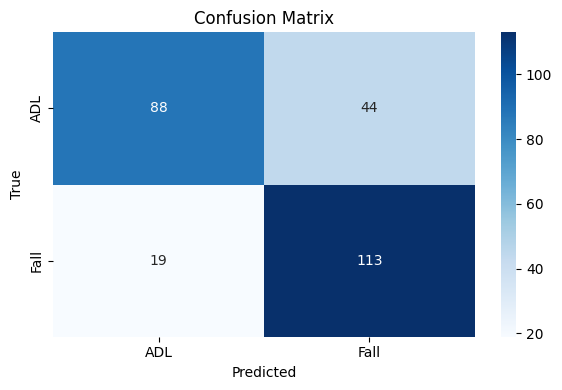


✅ Test Accuracy: 0.76

📝 Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.67      0.74       132
           1       0.72      0.86      0.78       132

    accuracy                           0.76       264
   macro avg       0.77      0.76      0.76       264
weighted avg       0.77      0.76      0.76       264



In [6]:
model, history = run_fall_detection_model(X_acc, X_all, y)

Removed 19 samples due to NaNs.
✅ SMOTE applied
X shape: (1318, 300, 6)
Label counts: [659 659]
Epoch 1/20


/Users/amir/Documents/projects/fall-detection/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6464 - loss: 0.6398 - val_accuracy: 0.7725 - val_loss: 0.4731
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8306 - loss: 0.4197 - val_accuracy: 0.7962 - val_loss: 0.4495
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8356 - loss: 0.3921 - val_accuracy: 0.8057 - val_loss: 0.4675
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8416 - loss: 0.3786 - val_accuracy: 0.7962 - val_loss: 0.4772
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8676 - loss: 0.3378 - val_accuracy: 0.7867 - val_loss: 0.4832
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8676 - loss: 0.3114 - val_accuracy: 0.7915 - val_loss: 0.4906
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8295 - loss: 0.3442 - val_accuracy: 0.8009 - val_loss: 0.5276
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8581 - loss: 0.3116 - val_accuracy: 0.8009 - val_loss: 0.5878
Epo

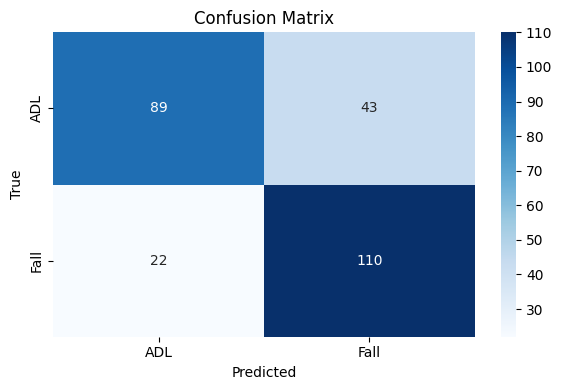


✅ Test Accuracy: 0.75

📝 Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.67      0.73       132
           1       0.72      0.83      0.77       132

    accuracy                           0.75       264
   macro avg       0.76      0.75      0.75       264
weighted avg       0.76      0.75      0.75       264



In [7]:
model, history = run_fall_detection_model(X_acc, X_all, y, use_gyro=True)

Removed 19 samples due to NaNs.
Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7376 - loss: 0.5497 - val_accuracy: 0.7518 - val_loss: 0.4554
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7862 - loss: 0.3893 - val_accuracy: 0.7518 - val_loss: 0.4492
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7831 - loss: 0.3758 - val_accuracy: 0.7445 - val_loss: 0.4048
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7709 - loss: 0.3827 - val_accuracy: 0.7445 - val_loss: 0.4419
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7602 - loss: 0.3697 - val_accuracy: 0.7372 - val_loss: 0.4174
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7954 - loss: 0.3438 - val_accuracy: 0.7299 - val_loss: 0.4302
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7822 - loss: 0.3430 - val_accuracy: 0.6861 - val_loss: 0.4368
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8169 - loss: 0.3392 - 

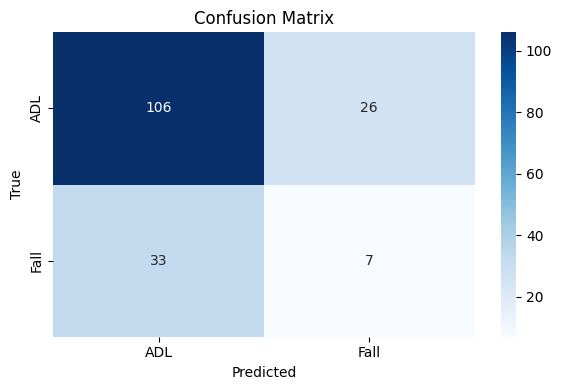


✅ Test Accuracy: 0.66

📝 Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.80      0.78       132
           1       0.21      0.17      0.19        40

    accuracy                           0.66       172
   macro avg       0.49      0.49      0.49       172
weighted avg       0.63      0.66      0.64       172



In [8]:
# Without SMOTE

model, history = run_fall_detection_model(X_acc, X_all, y, apply_smote=False)